# Cambiamenti climatici

## Requisiti:

In [4]:
# !pip install pandas
# !pip install tabulate
# !pip install matplotlib 
# !pip install plotly

## 1. Data collection
I dati usati in questa applicazione si trovano nella cartella [data](applicazione/data/). 
<ul>
    <li>In original si trovano i file originali trovati su internet</li>
    <li>In modified si trovano i file "processati"</li>
</ul>

## Dati sulle temperature e sulle stazioni geografiche
I file contenenti i dati relativi alle temperature ([temperatures.dat](applicazione/data/original/temperatures.dat)) e alle stazioni geografiche ([stations.inv](applicazione/data/original/stations.inv)) sono stati trovati sul sito [National Centers for Environmental Information](https://www.ncei.noaa.gov/). Sono scaricabili al seguente link: https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcf.tar.gz <br>


## Dati sui Paesi
I file contenenti informazioni sui Paesi sono stati trovati su due repository di github: <br>
- [fips_to_iso_country_codes.csv](applicazione/data/original/fips_to_iso_country_codes.csv) trovato al seguente link: https://github.com/mysociety/gaze/blob/master/data/fips-10-4-to-iso-country-codes.csv <br>
- [countries_info.csv](applicazione/data/original/countries_info.csv) trovato al seguente link https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv <br>

## Dati sui livelli del mare e sui livelli di CO2
I file [sea_levels.csv](applicazione/data/original/sea_levels.csv) e [co2_levels.csv](applicazione/data/original/co2_levels.csv) sono stati trovato su Kaggle rispettivamente ai link https://www.kaggle.com/datasets/kkhandekar/global-sea-level-1993-2021 e https://www.kaggle.com/datasets/programmerrdai/co2-levels-globally-from-fossil-fuels

## 2. Data processing

In [5]:
import pandas as pd
import os

pd.options.display.max_rows = None
pd.options.display.max_columns = None
# pd.set_option('display.', None)

DATA_FOLDER = "applicazione" + os.path.sep + "data" + os.path.sep
DATA_ORIGINAL_FOLDER = DATA_FOLDER + "original"+ os.path.sep
DATA_MODIFIED_FOLDER = DATA_FOLDER + "modified"+ os.path.sep

### Stazioni e temperature
I file [stations.inv](applicazione/data/original/stations.inv) e [temperatures.dat](applicazione/data/original/temperatures.dat) trovati su internet sono Fixed Width Text File. Ho deciso di modificarli e convertirli in file CSV ([stations_created.csv](applicazione/data/modified/stations_created.csv), [tempetatures_created.csv](applicazione/data/modified/tempetatures_created.csv)). In questo modo creo due file CSV con i dati già "puliti" e pronti per essere letti. Inoltre, la funzione read_csv per leggere file CSV è molto più veloce di read_fwf per leggere file Fixed Width, quindi <mark> continua... </mark>
<br>

#### Stazioni
Il file [stations_created.csv](applicazione/data/modified/stations_created.csv) ha la seguente struttura:
|Campo| Significato|
|:-|:-|
|station_id| Codice identificativo della stazione. I primi due caratteri sono il codice FIPS del Paese|
|latitude| Latitudine della stazione in gradi decimali|
|longitude| Longitudine della stazione in gradi decimali|
|station_elev| Altitudine della stazione in metri; <mark> FORSE NON E' COSI' il valore -999.0 indica un dato mancante|
|station_name| Nome della stazione|
|fips| Codice FIPS del Paese|

Ho creato uno script per creare il file:

In [6]:
import calendar

# File con le stazioni
FILE_ORIGINALE_STATIONS = DATA_ORIGINAL_FOLDER + "stations.inv"
FILE_CSV_STATIONS = DATA_MODIFIED_FOLDER + "stations_created.csv"
HEADERS_STATIONS = ["station_id","latitude","longitude","station_elev","station_name"]

if not os.path.exists(FILE_CSV_STATIONS):
    print("Creo file csv partendo da",FILE_ORIGINALE_STATIONS,"...")
    
    # Leggo il file
    df = pd.read_fwf(FILE_ORIGINALE_STATIONS,widths=[11,9,10,7,31], header=None, names=HEADERS_STATIONS)
    
    # Aggiungo il campo fips
    df['fips'] = df["station_id"].apply(lambda x : x[0:2])
    HEADERS_STATIONS += ["fips"]
    
    # Trasformo i valori -999.0 di station_elev in Nan
    df["station_elev"] = df["station_elev"].apply(lambda x: pd.NA if x == 9999 else x)

    # Converto in formato CSV
    df.to_csv(FILE_CSV_STATIONS, index=False)
print("File creato correttamente!")

File creato correttamente!


#### tempetatures_created.csv
Il file [tempetatures_created.csv](applicazione/data/modified/stations_created.csv) ha la seguente struttura:
|Campo| Significato|
|:-|:-|
|station_id| Codice identificativo della stazione. I primi due caratteri sono il codice FIPS del Paese|
|year| Anno in cui sono state misurate le temperature|
|month_value| Valore della temperatura del mese "month". I valori della temperatura sono in centesimi di grado Celsius, ma sono espressi come numeri interi (ad es. dividere per 100,0 per ottenere gradi Celsius interi). <br>Il valore -9999 indica un dato mancante. |
|<mark>TOLTO month_dm_flag| data measurement flag (indicatore della misurazione dei dati). <br>Se è vuoto -> nessuna informazione di misurazione applicabile <br> Se è una lettera tra a-i -> numero di giorni mancanti nel calcolo della temperatura media mensile |
|<mark>CAMBIATO month_qc_flag| quality control flag del mese "month". <br> Se è vuoto, non c'è stato nessun fallimento del controllo di qualità oppure il valore non può essere valutato. <br> Per gli altri valori, consultare la [documentazione dei dataset]((https://www.ncei.noaa.gov/pub/data/ghcn/v4/readme.txt)) |
|<mark>TOLTO month_ds_flag| Indica l'origine dati per il valore del mese "month". Per avere altre informazioni, consultare la [documentazione di tale campo](https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm-flags.txt)|

Ho creato uno script per creare il file:


In [7]:
# File con le temperature
FILE_ORIGINALE_TEMPERATURES = DATA_ORIGINAL_FOLDER + "temperatures.dat"
FILE_CSV_TEMPERATURES = DATA_MODIFIED_FOLDER + "temperatures_created.csv"

# Creo due liste: una con le lunghezze dei campi e una con i nomi delle colonne
list_width= [11,4,4] + [j for i in [[5,1,1,1] for _ in range(12)] for j in i] 
# print(list_width)
HEADERS_TEMPERATURES = ["station_id", "year", "DEL_ME"]
for i in range(1,13):
    month_name = calendar.month_name[i]
    HEADERS_TEMPERATURES += [month_name+"_value","DEL_ME"+str(i)+"a",month_name+"_qc_flag","DEL_ME"+str(i)+"b"]

if not os.path.exists(FILE_CSV_TEMPERATURES):
    print("Creo file csv partendo da",FILE_ORIGINALE_TEMPERATURES,"...")
    
    # Leggo il file
    df = pd.read_fwf(FILE_ORIGINALE_TEMPERATURES, widths=list_width,header=None, names=HEADERS_TEMPERATURES)
    
    # Elimino le colonne non necessarie
    HEADERS_TEMPERATURES = [i for i in HEADERS_TEMPERATURES if not i.__contains__("DEL_ME")]
    df = df[HEADERS_TEMPERATURES]

    # Cambio i valori valori "vuoti" di month_qc_flag con un trattino. Questi valori vuoti, indicano che 
    # non ci sono stati problemi durante la rilevazione dei dati, non indicano dati mancanti.
    # Cambio i valori -9999 di month_value con NaN. Trasformo anche i valori validi in gradi decimali. 
    for i in range(1,13):
        month_name = calendar.month_name[i]
        df[month_name+"_qc_flag"] = df[month_name+"_qc_flag"].apply(lambda x: "-" if pd.isna(x) else x)
        df[month_name+"_value"] = df[month_name+"_value"].apply(lambda x: pd.NA if str(x) == "-9999" else x/100)

    #  TODO Rimuovo i record con valori nulli
    #df = df.dropna()
    
    # Converto in formato CSV
    df.to_csv(FILE_CSV_TEMPERATURES, index=False)

print("File creato correttamente!")

File creato correttamente!


### Paesi
Per quanto riguarda le informazioni sui paesi, ho unito i due file [country_info.csv](applicazione/data/original/countries_info.csv) e [fips_to_iso_country_codes.csv](applicazione/data/original/fips_to_iso_country_codes.csv) in un unico file [countries_created.csv](applicazione/data/original/countries_created.csv) con la seguente struttura:

|Campo|Significato|
|:-|:-|
|fips| Codice FIPS del paese|
|name_country| Nome del Paese|
|region| Continente di appartenenza|
|sub-region| Zona del continente (nord, sud, est, ovest)|
|region-code| Codice di region|
|sub-region-code| Codice di sub-region|

Ho creato uno script per creare il file:

In [8]:
# File dei paesi
FILE_ORIGINALE_FIPS_TO_ISO = DATA_ORIGINAL_FOLDER + "fips_to_iso_country_codes.csv"
FILE_ORIGINALE_COUNTRY_INFO = DATA_ORIGINAL_FOLDER + "countries_info.csv"
FILE_CSV_COUNTRIES_CREATED = DATA_MODIFIED_FOLDER + "countries_created.csv"

if not os.path.exists(FILE_CSV_COUNTRIES_CREATED):
    print("Creo file csv partendo da",FILE_ORIGINALE_FIPS_TO_ISO, "e", FILE_ORIGINALE_COUNTRY_INFO,"...")

    # Leggo i files originali
    df_fips = pd.read_csv(FILE_ORIGINALE_FIPS_TO_ISO)
    df_country = pd.read_csv(FILE_ORIGINALE_COUNTRY_INFO)

    # Faccio il join sul codice alpha-2
    merged = pd.merge(df_fips, df_country, how='left',left_on='ISO 3166', right_on='alpha-2')

    # Elimino le colonne non necessarie e rinomino le altre
    merged = merged.drop(['ISO 3166','iso_3166-2', 'alpha-3', 'alpha-2', 'country-code', 'intermediate-region', 'intermediate-region-code'], axis=1)
    merged['name_country'] = merged.apply(lambda x : str(x['Name'] if pd.isna(x["name"]) else x['name']), axis=1)
    merged = merged.drop([ 'name', 'Name'], axis=1)
    merged = merged.rename(columns={"FIPS 10-4":"fips"})

    # e creo un nuovo file
    merged.to_csv(FILE_CSV_COUNTRIES_CREATED, index=False, header=True)

print("File creato correttamente!")

File creato correttamente!


### Livelli di CO2 e livelli del mare
I file trovati su Internet relativi ai livelli di CO2 e ai livelli del mare non hanno bisogno di essere troppo "processati". Quindi non ho creato dei nuovi file CSV. Per i due file, ne leggo i dati mediante la funzione read_csv e ne seleziono i seguenti campi:

#### Livelli di C02
|Campo| Significato|
|:-|:-|
|year| anno (impostato come indice)|
|co2_level| Emissioni totali di carbonio derivanti dal consumo di combustibili fossili e dalla produzione di cemento (in milioni di tonnellate di C)|

#### Livelli del mare
|Campo| Significato|
|:-|:-|
|year| anno (impostato come indice)|
|gmsl_variation| Variazione Global Mean Sea Level (mm) rispetto al riferimento della media collineare TOPEX/Jason su 20 anni  |

In questo file ci sono più record per anno, ho deciso di mantenerne solo uno, che ne rappresenti la media.

In [9]:
df_co2 = pd.read_csv(DATA_ORIGINAL_FOLDER + "co2_levels.csv")
df_co2 = df_co2[["Year", "Total"]]
df_co2 = df_co2.rename(columns={"Year":"year", "Total": "co2_level"})
df_co2 = df_co2.set_index("year")
# display(df_co2.head(5))

df_sea = pd.read_csv(DATA_ORIGINAL_FOLDER + "sea_levels.csv")
df_sea = df_sea[["Year", "GMSL_noGIA"]]
df_sea = df_sea.rename(columns={"Year":"year", "GMSL_noGIA": "gmsl_variation"})
df_sea = df_sea.groupby("year").mean()
# display(df_sea.head(5))

## 3. Elaborazione dei dati <mark>(?)

Una volta creati tutti i file CSV, per usarli basterà leggerli e fare il join sul campo 'fips' e 'station_id':

In [10]:
df_temperatures = pd.read_csv(FILE_CSV_TEMPERATURES).dropna()
df_stations = pd.read_csv(FILE_CSV_STATIONS)
df_country = pd.read_csv(FILE_CSV_COUNTRIES_CREATED)

1. Esistono i cambiamenti climatici? 
    - Mostrare mappa del mondo delle temperature medie nel 19**
    - Mostrare mappa delle temperature medie nel 2020 e 2021
    - Mostrare un grafico con i cambiamenti
2. Perché dobbiamo fare qualcosa per fermarli?
    - Mostrare grafico di come saranno le temperature nel 2100 (seguendo il trend)
3. Altra conseguenza: innalzamento dei livelli del mare
4. Quali paesi risentono di piu' dei cambiamenti climatici?
    - Mostrare un grafico a colonne
4. Anni piu' caldo


---
Quando le stazioni hanno iniziato a raccogliere dati? Qual è stata la prima a raccogliere dati?
Quante stazioni per ogni paese?
Quale contienente ha piu' stazioni?
Quale stazione ha raccolto piu' dati?


In [11]:
# Stampo le statistiche 
df_describe = df_temperatures.describe(include='all')

# Sistemo l'output
df_describe["year"] = df_describe["year"].apply(lambda x: '{:.0f}'.format(x))
for i in range(1,13):
    df_describe[calendar.month_name[i]+"_value"] = df_describe[calendar.month_name[i]+"_value"].apply(lambda x: '{:.0f}'.format(x) if pd.isna(x) or int(x) == x else  '{:.2f}'.format(x))

display(df_describe)

,station_id,year,January_value,January_qc_flag,February_value,February_qc_flag,March_value,March_qc_flag,April_value,April_qc_flag,May_value,May_qc_flag,June_value,June_qc_flag,July_value,July_qc_flag,August_value,August_qc_flag,September_value,September_qc_flag,October_value,October_qc_flag,November_value,November_qc_flag,December_value,December_qc_flag
count,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549
unique,27769,nan,nan,9,nan,9,nan,9,nan,9,nan,9,nan,9,nan,9,nan,9,nan,9,nan,9,nan,9,nan,9
top,NLM00006260,nan,nan,-,nan,-,nan,-,nan,-,nan,-,nan,-,nan,-,nan,-,nan,-,nan,-,nan,-,nan,-
freq,316,nan,nan,1055141,nan,1055345,nan,1055345,nan,1055006,nan,1054835,nan,1054540,nan,1054227,nan,1054128,nan,1054582,nan,1054930,nan,1055049,nan,1055130
mean,NaN,1970,1.17,NaN,2.47,NaN,6.16,NaN,10.70,NaN,14.97,NaN,18.56,NaN,20.68,NaN,20.12,NaN,16.93,NaN,12.15,NaN,6.75,NaN,2.60,NaN
std,NaN,36,12.83,NaN,12.39,NaN,10.61,NaN,8.39,NaN,6.86,NaN,6.31,NaN,6.17,NaN,6.13,NaN,6.49,NaN,7.72,NaN,9.94,NaN,11.89,NaN
min,NaN,1702,-61.03,NaN,-61,NaN,-62.10,NaN,-68.60,NaN,-70.30,NaN,-72.83,NaN,-73.80,NaN,-75,NaN,-71.05,NaN,-70.50,NaN,-77,NaN,-72.79,NaN
25%,NaN,1950,-6.51,NaN,-5.30,NaN,-0.52,NaN,5.53,NaN,10.84,NaN,14.57,NaN,17.02,NaN,16.29,NaN,12.71,NaN,7.42,NaN,1.04,NaN,-4.38,NaN
50%,NaN,1975,-0.13,NaN,1.26,NaN,5.10,NaN,9.81,NaN,14.40,NaN,18.38,NaN,21.05,NaN,20.29,NaN,16.49,NaN,11.37,NaN,5.55,NaN,1.21,NaN
75%,NaN,1998,7.80,NaN,9.35,NaN,12.46,NaN,15.72,NaN,19.02,NaN,22.91,NaN,25.17,NaN,24.60,NaN,21.48,NaN,16.95,NaN,12.54,NaN,8.78,NaN


<mark>
Considerazioni: ci sono in totale 27769 stazioni, l'anno minimo è il 1702 e il massimo il 2021, ...

### Esiste l'effetto serra?

In [120]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

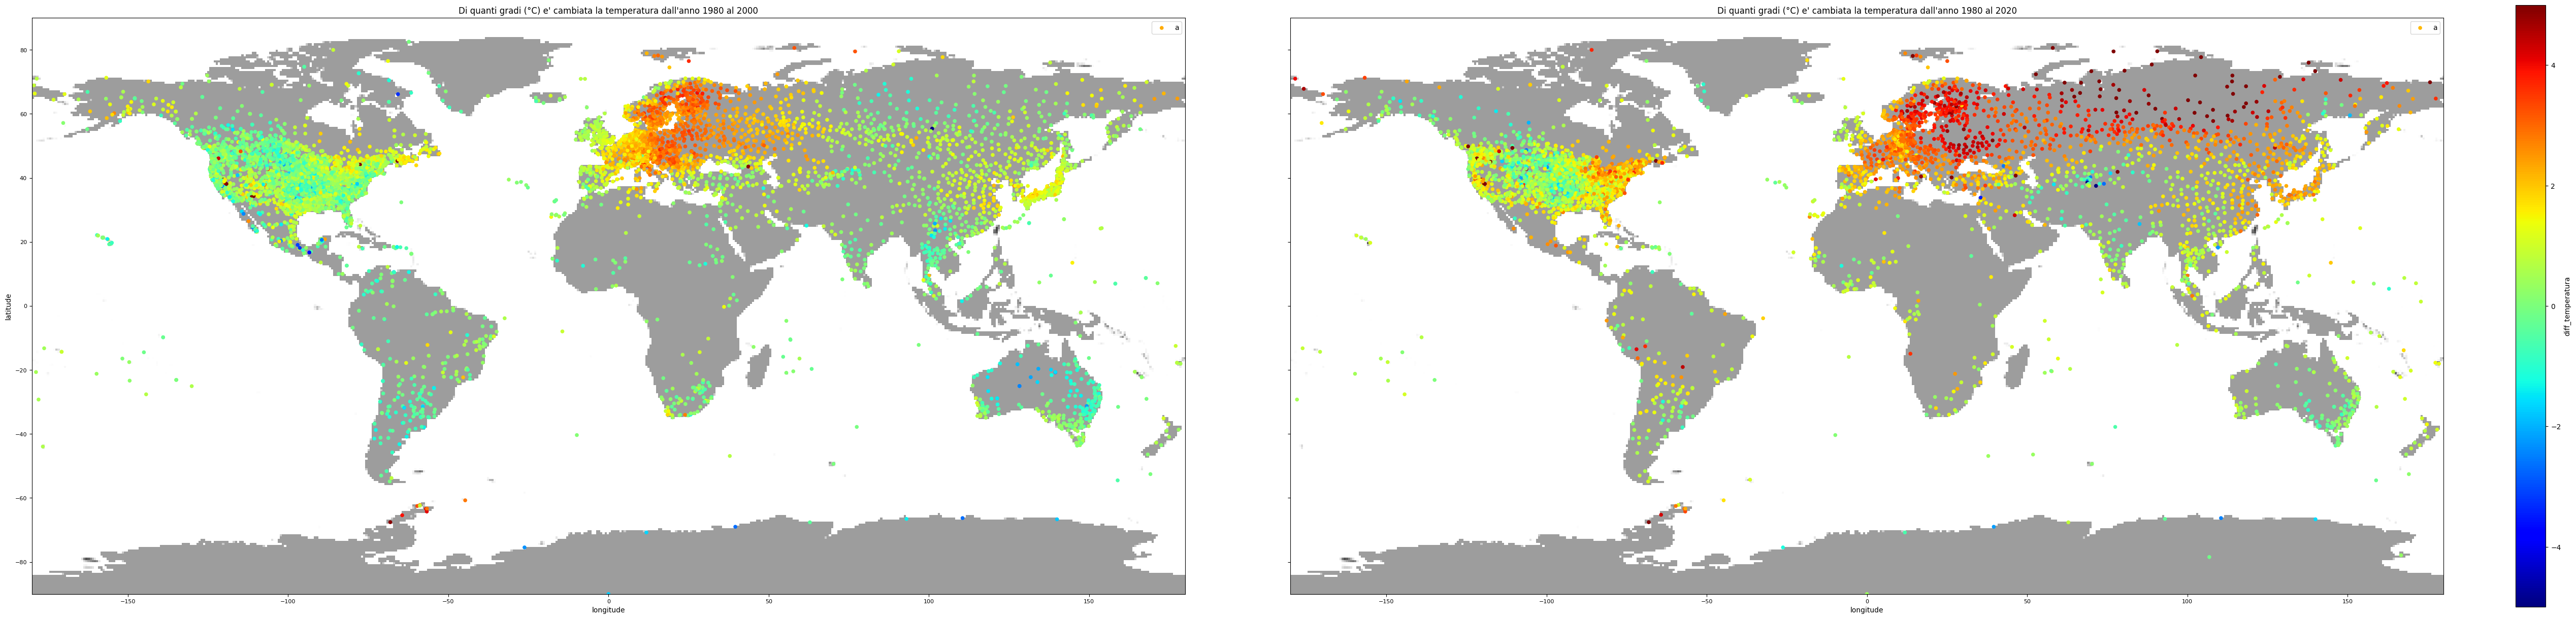

In [239]:
import matplotlib.pyplot as plt

def plot_map_difference_temperatures(list_years):
    """ Funzione che disegna i grafici con le differenze di temperature degli anni dati in input."""
    def plot_map_two_years(year1, year2, i):
        def get_col_name(year):
            return 'temperatura_year_'+str(year)
        
        def get_df(anno):
            """Questa funzione ritorna un DataFrame contenente le rilevazioni delle temperature dell'anno dato in input.
            Il dataframe in output ha i seguenti campi:
                station_id, latitude, longitude -> informazioni delle stazioni
                year -> anno in input
                temperatura_year_anno -> temperatura media dell'anno 'anno' in input
            """
            df_to_plot = df_temperatures[(df_temperatures["year"] == anno)]    # Seleziono solo l'anno desiderato
            df_to_plot = df_to_plot.merge(df_stations, on="station_id")        # Faccio il merge con le stazioni
            df_to_plot[get_col_name(anno)] = df_to_plot[[calendar.month_name[i]+"_value" for i in range(1,13)]].mean(axis=1)    # Calcolo la temperatura media annuale 
            df_to_plot = df_to_plot[["station_id", "year","latitude", "longitude", get_col_name(anno)]]                         # Seleziono solo alcuni campi
            return df_to_plot   
    
        # Faccio il merge dei due dataframe dei due anni in input, in base alla station_id
        df = get_df(year1).merge(get_df(year2), how="inner",  on=["station_id", "latitude", "longitude"])

        # Calcolo la differenza della temperatura media annuale
        df['diff_temperatura'] = df[get_col_name(year2)] - df[get_col_name(year1)]
        
        # Setto gli estremi della latitudine e la longitudine, in modo da far combaciare la cartina geografica in background
        ylim=(-90,90)#(df["latitude"].min(), df["latitude"].max())
        xlim=(-180,180)#(df["longitude"].min(), df["longitude"].max())

        # Disegno il grafico
        titolo = "Di quanti gradi (°C) e' cambiata la temperatura dall'anno "+str(year1)+" al " + str(year2)
        grafico = df.plot(x="longitude", y="latitude", label="a",c="diff_temperatura",fontsize=8, ylim=ylim, xlim=xlim, \
            clim=(-5,5),kind="scatter", colormap="jet", title=titolo, ax=axes[i], figsize=(54,27))#, figsize=(20, 10))
        

        # fig2 = plt.figure()


        # TODO da cambiare path ed eventualemnte foto
        img = plt.imread("applicazione/data/imgs/world3_new.png")
        grafico2 = grafico.imshow(img, extent=[xlim[0], xlim[1], ylim[0], ylim[1]])


        # print(type(grafico))
        # print(type(grafico2))

        # grafico.colorbar.remove()
        # fig.colorbar(grafico2, ax=axes[i] ).remove()
    
        # TODO rimuovi legenda/colorbar
        # print(dir(plt.colorbar(grafico2).set_alpha(0)))
        # print(dir())
        # cb = grafico._colorbars
        # cb.remove() 
    
    fig, axes = plt.subplots(nrows=1,ncols=len(list_years)-1, sharey=True, figsize=(2,2))

   
    i=0
    for anno2 in list_years[1:]:
        plot_map_two_years(list_years[0], anno2, i)
        i += 1
    
    # Abbellimenti: lascio solo l'ultima colorbar, tolgo lo spazio tra i grafici, setto l'altezza finale
    f = plt.gcf()
    j = 0
    for i in f.get_axes():
        if i._label == "<colorbar>":
            if j != len(list_years)-2:
                i.remove()
            j += 1
    fig.tight_layout()
    fig.set_figheight(12)

    plt.show()


# Disegno le mappe
# plot_map_difference_temperatures([1960, 1980,2000, 2020])
plot_map_difference_temperatures([1980, 2000,2020])#, 2020])

<mark>
Considerazioni: si può notare che la temperatura è in aumento + discorso sui continenti mancanti

Di quanti gradi (°C) si è alzata la temperatura dal 1960 ad oggi?
- Calcolare la temperatura media annuale di ogni anno di ogni stazione
- Prendere 5 stazioni (1 per ogni continente) e 2 anni per stazione. La stazione e gli anni devono essere prese in modo da far vedere la massima differenza di temperatura registrata.
- Fare 5 subplot facendo vedere i cambiamenti


### In quali anni e in quali stazioni è stata registrata la maggiore differenza di temperatura?
L'output è in gradi °C

'Stazione: COLIMA (Mexico)'

,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2021,25.15,24.45,25.95,26.80,28.15,27.65,28.05,27.40,27.00,27.55,29.15,25.7
1990,-2.18,-2.35,-1.61,-0.77,-1.07,0.40,-0.07,-0.61,-1.24,-2.43,-2.91,-2.5


'Stazione: HERMANOS_SERDAN_INTL (Mexico)'

,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2021,15.70,16.60,19.55,20.60,20.25,18.95,18.85,18.80,18.60,18.25,15.50,15.95
1990,-5.34,-4.61,-4.51,-5.83,-5.37,-3.51,-5.31,-6.56,-6.14,-6.76,-7.16,-8.55


'Stazione: SUMMIT_OREGON (United States of America)'

,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2021,-0.59,-1.53,0.95,6.2,9.41,17.86,22.71,19.29,15.25,7.05,4.51,-1.23
1990,-50.00,-50.00,-50.00,-50.0,-10.03,11.98,18.18,16.55,14.88,7.04,1.48,-5.80


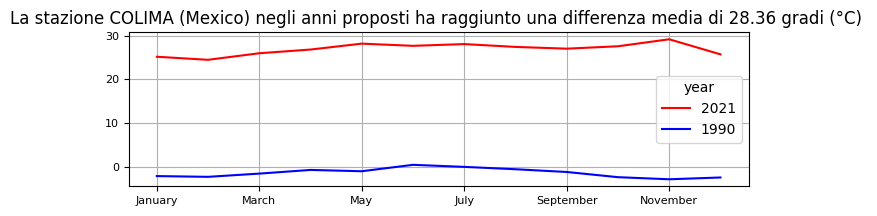

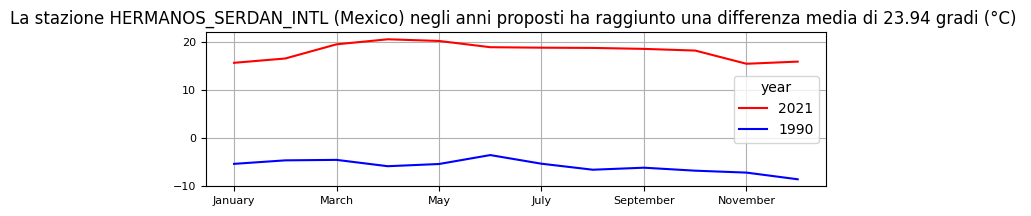

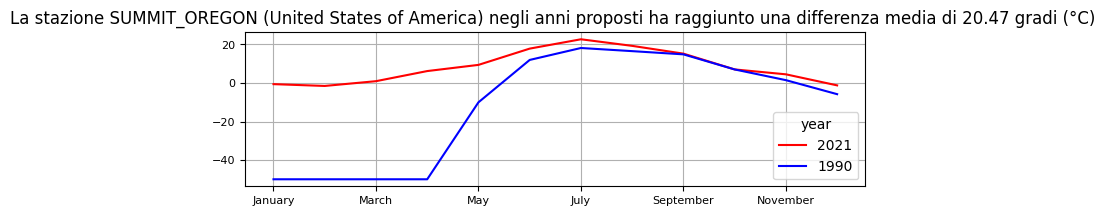

In [13]:
# Numero di grafici da mostrare
N = 3

# Calcolo la temperatura media annuale di ogni record
df = df_temperatures.copy()
df["temp_media"] = df_temperatures[[calendar.month_name[i]+"_value" for i in range(1,13)]].mean(axis=1)    
df = df[["station_id", "year", "temp_media"]]

# Per ogni stazione, seleziono due record: quello con l'anno minimo e quello con l'anno massimo
df_min = df.sort_values("year").groupby("station_id", as_index=False).first()
df_max = df.sort_values("year", ascending=False).groupby("station_id", as_index=False).first()
df = pd.concat([df_min, df_max]).sort_values(by=["station_id", "year"])

# Per ogni record rimasto, calcolo la differenza di temperatura media tra l'anno massimo e quello minimo
df["diff"] = df.groupby(['station_id'])['temp_media'].diff()

# Ordino i record in base alla differenza (decrescente) appena calcolata. Seleziono solo i primi N record
df_first_n_record = df.sort_values(by="diff", ascending=False).head(N)

# In df_first_n_record saranno present solo  record con gli anni massimi. Aggiungo quelli con gli anni minimi
df_tmp = df_first_n_record
for _, record in df_first_n_record.iterrows():
    record2 = df[(df["station_id"] == record["station_id"]) & (pd.isna(df["diff"]))]
    df_tmp = pd.concat([df_tmp, record2])

# Faccio il merge con i dati delle stazioni e dei paesi
df = df_tmp.merge(df_stations, on="station_id").merge(df_country, on="fips").merge(df_temperatures, on=["station_id", "year"])

# Per ogni stazione, stampo un grafico
for _, record in df_first_n_record.iterrows():
    # Seleziono i due record della stazione
    df_station_to_plot = df[df["station_id"] == record["station_id"]]

    nome_stazione = df_station_to_plot.iloc[1]["station_name"] 
    nome_country = df_station_to_plot.iloc[1]["name_country"] 
    titolo = "La stazione "+ nome_stazione  +" ("+ nome_country  \
        + ") negli anni proposti ha raggiunto una differenza media di " + f"{df_station_to_plot['diff'].max():.2f}" + " gradi (°C) "

    # Imposto l'anno come indice. Tengo solo le temperature misurate nei 12 mesi. Cambio i nomi alle colonne
    df_station_to_plot = df_station_to_plot.set_index(["year"])
    df_station_to_plot = df_station_to_plot[[calendar.month_name[i]+"_value" for i in range(1,13)]]                         
    df_station_to_plot = df_station_to_plot.rename(columns={calendar.month_name[i]+"_value":calendar.month_name[i] for i in range(1,13)})
    display("Stazione: "+ nome_stazione +" ("+ nome_country+ ")", df_station_to_plot)
    # Disegno il grafico, con la griglia in background
    df_station_to_plot.transpose().plot(figsize=(8,2), fontsize=8, title=titolo, color=['red', 'blue'])
    plt.grid(True)


### I livelli dei mari si stanno alzando?

,gmsl_variation
year,
1993,-34.605405
2021,50.031111


Dal 1993 al 2021 i livelli del mare si sono alzati di 84.64 mm. Per una media di 3.02 mm all'anno.


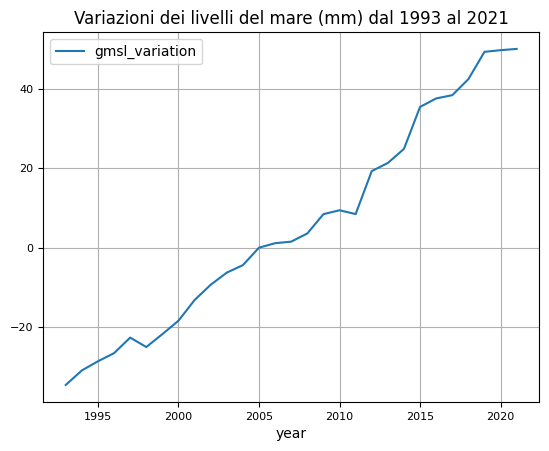

In [89]:
# Stampo le variazioni del primo e dell'ultimo anno
df_sea_to_print = df_sea.iloc[[0, -1]]
min_year, max_year = df_sea_to_print.index.min(), df_sea_to_print.index.max()
display(df_sea_to_print)

# Disegno il grafico
titolo = "Variazioni dei livelli del mare (mm) dal "+ str(min_year) + " al " + str(max_year)
df_sea.plot(fontsize=8, title=titolo)
plt.grid(True)

# Stampo la differenza
differenza_totale = df_sea_to_print.diff().dropna()['gmsl_variation'].item()
media = differenza_totale / (max_year-min_year)
print("Dal",min_year ,"al", max_year, "i livelli del mare si sono alzati di", f"{differenza_totale:.2f}","mm. Per una media di", f"{media:.2f}", "mm all'anno.")

### Perchè dobbiamo fermarli? 
Se non li fermassimo, ecco come sarebbe la situazione in futuro:

In [ ]:
# print("len prima =\t", len(df_temperatures))
# for i in range(1,13):
#     df_temperatures = df_temperatures[df_temperatures[calendar.month_name[i]+"_value"] != pd.NA]
# print("len dopo =\t", len(df_temperatures))
# display(df_temperatures)


In [ ]:
# import tabulate

# df_merged = df_temperatues.merge(df_stations, on='station_id')
# df_merged = df_merged.merge(df_country, on='fips')
# colonne = ["station_id", "year", "station_name", "latitude", "longitude", "station_elev", "region", "sub-region"] + [str(calendar.month_name[i]+"_value") for i in range(1,13)]

# table = tabulate.tabulate(df_merged[colonne].sample(n=5), headers='keys', tablefmt='html')
# display(table)

## 

In [ ]:
# df_temperatues = pd.read_csv(FILE_CSV_TEMPERATURES)

In [ ]:
# for i in range(1,13):
#     month_name = calendar.month_name[i]
#     print("********")
#     new_df  = df_temperatues
    
    
#     new_df[month_name+"_qc_flag"] = df_temperatues[month_name+"_qc_flag"].apply(lambda x: "-" if pd.isna(x) else x)
#     prova = new_df[new_df[month_name+"_qc_flag"] == "-"]
#    # lista = list(set(prova.to_list()))
#     print(month_name, len(prova))

    

In [ ]:

# # for index, row in merged.iterrows():
# #     print(f"{index:5}", f"{row['name']:50}",row['fips'])


# # print(merged)

# df_stations = pd.read_csv(FILE_CSV_STATIONS)
# # print(len(pd.unique(df_stations['fips'])))
# # 
# merged2 = df_stations.merge(merged, how='left', on='fips')
# # merged2 = merged2.drop(['name_country', 'region', 'sub-region', 'region-code', 'sub-region-code'], axis=1)
# merged2 = merged2.drop_duplicates() 
# merged2 = merged2.reset_index()

# # print(merged2)
# for index, row in merged2.iterrows():
#     print(str(row).replace("\n","\t",-1))

